In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [2]:
pathSave = "/plp_user/agar_si/gaia/python/AGU2021_Tutorial/"

### Introduction
This tutorial compares linear regression with feed-forward neural networks for "low-dimensional" surrogate modeling. We use a dataset of 2D computational fluid dynamic simulations of the mantle (highly viscous flow) for a Mars-like planet. The regression task is to predict the 1D temperature profile from five simulation parameters at any point in the 4.5 Gyr evolution. By the end of this tutorial, you will know how to build, train and load a feed-forward neural network using [Keras](https://keras.io/). 

<img src="Diagrams-Concept-1D.svg" alt="Drawing" style="width: 720px;"/>

### Tutorial structure
There are three modules:
> **Module 1** Data processing <br> 
> **Module 2** Training regression algorithms <br> 
> **Module 3** Testing accuracy of trained algorithms <br> 

### To dos
Headings marked in <font color='blue'>blue</font> indicate that the following cell needs to be completed. Each line of code that needs to be added is further indicated by <font color='grey'>"### TO DO"</font>. You will need to replace all instances where <font color='blue'>---</font> appears. We will go through all the cells together, but feel free to check the "Regression_Tutorial_sol.ipynb" notebook for example solutions.

# Module 1/3: Data processing

### Specify the number of simulations to use for training

The dataset contains a total of 10525 simulations for a Mars-like planet carried out in a quarter-cylindrical 2D geometry. 1D temperature profiles and the input parameters for the simulations have already been extracted and stored as arrays in Data/processed/

The following numbers of numTrainingSims can be specified: 100, 1000, 3000, 6000, 9877. We specify 1000 for a good balance between speed and accuracy.

In [3]:
numTrainingSims = 1000

### Load the data

Here we load the following data: <br>
> **training:** used to train the regression algorithms <br>
> **cross-validation:** used to monitor how the algorithm is performing on unseen data during training. It can also be used to search through different architectures. <br>
> **test:** use to evaluate the accuracy of the predictions

In [4]:
with open(pathSave + "Data/processed/x_train_" + str(numTrainingSims) + "Sims.txt", "rb") as f:
    x_train = pickle.load(f)
with open(pathSave + "Data/processed/y_train_" + str(numTrainingSims) + "Sims.txt", "rb") as f:
    y_train = pickle.load(f)

with open(pathSave + "Data/processed/x_cv.txt", "rb") as f:
    x_cv = pickle.load(f)
with open(pathSave + "Data/processed/y_cv.txt", "rb") as f:
    y_cv = pickle.load(f)
    
with open(pathSave + "Data/processed/x_test.txt", "rb") as f:
    x_test = pickle.load(f)
with open(pathSave + "Data/processed/y_test.txt", "rb") as f:
    y_test = pickle.load(f)

### <font color='blue'>Print the shape of the data</font>

Let's print the shape of the arrays above using *.shape*

Both, the input and output arrays generally have the shape of (number_examples, dimension of each example). Since, each simulation is broken into time-steps, each example for us is then 1 time-step of a simulation.<br>
> **input:** Each example consists of 6 parameters: Time during the evolution, rayleigh number, activation energy of the diffusion creep, activation volume of the diffusion creep, crustal enrichment factor for radiogenic elements and initial mantle temperature. <br>
> **output:** 1D temperature profiles (302-dimensional) <br>

In [5]:
### TO DO
print("Training data        : " + str(x_train.shape) + " " + str(y_train.shape))

### TO DO
print("cross-validation data: " + str(x_cv.shape)    + " " + str(y_cv.shape))

### TO DO
print("Test data            : " + str(x_test.shape)    + " " + str(y_test.shape))

Training data        : (104946, 6) (104946, 302)
cross-validation data: (10191, 6) (10191, 302)
Test data            : (10102, 6) (10102, 302)


### Visualize the data

Let's plot both **x_train** and **y_train** to get an idea of if the parameter space is well covered and what scales the variables exist on.

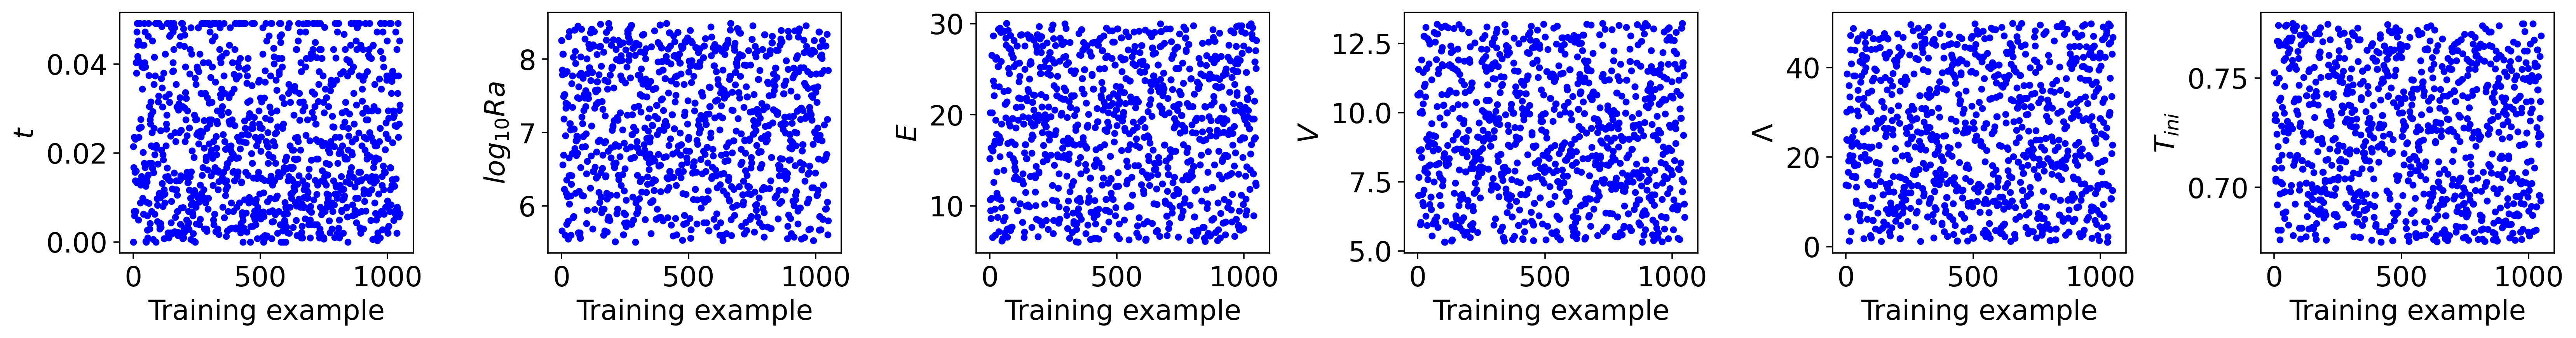

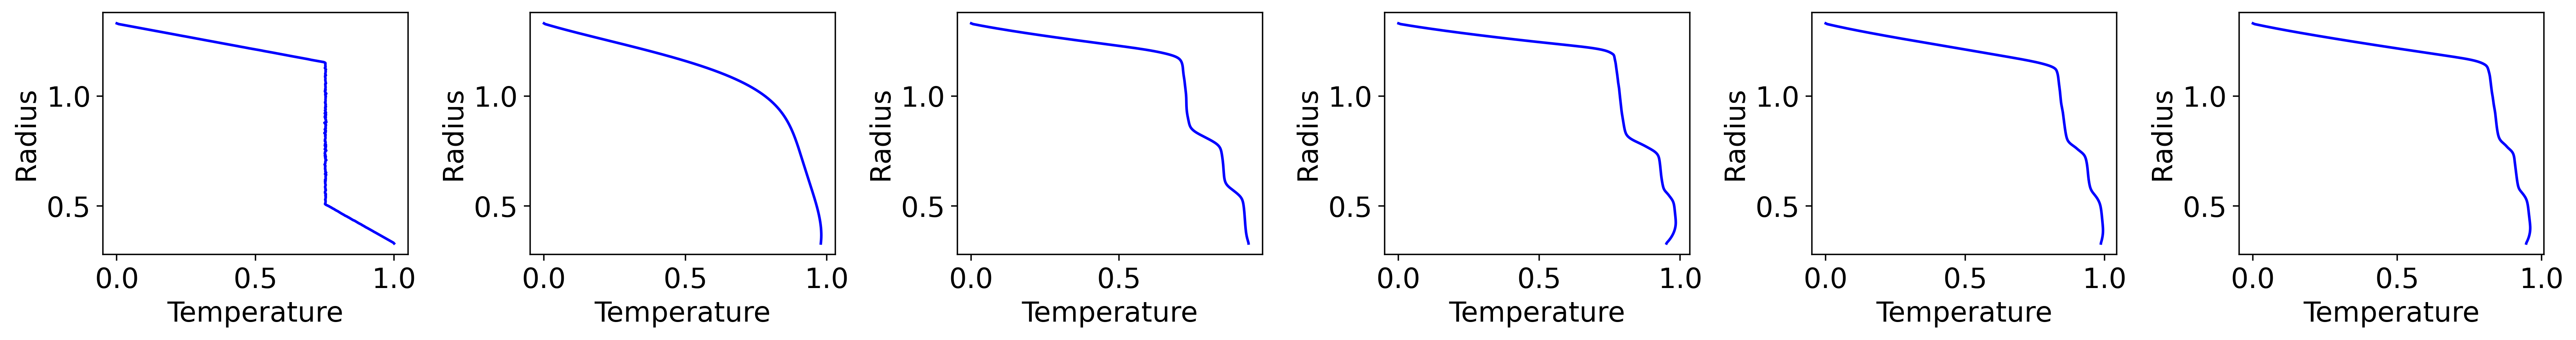

In [6]:
def visualize_parameters():
    parameter_vec = ["$t$", "$log_{10}Ra$", "$E$", "$V$", "$\Lambda$", "$T_{ini}$"]
    fig = plt.figure(figsize=(21,3), dpi=320)
    for i in range(len(parameter_vec)):
        ax = fig.add_subplot(1,len(parameter_vec),i+1)
        ax.plot(x_train[::100,i].flatten(),"b.")  # plotting only every 100th training example
        ax.set_ylabel(parameter_vec[i])
        ax.set_xlabel("Training example")
    plt.tight_layout(w_pad=0.001)
    plt.show()
    
visualize_parameters()

rProf = np.linspace(0.33, 1.33, 302)
fig = plt.figure(figsize=(21,3), dpi=320)
for i in range(6):           # plotting 6 example temperature profiles
    ax = fig.add_subplot(1,6,i+1)
    ax.plot(y_train[int(i*210),:],rProf,"b-")
    ax.set_ylabel("Radius")
    ax.set_xlabel("Temperature")
plt.tight_layout(w_pad=0.001)
plt.show()

### <font color='blue'>Define a function to scale data</font>

For gradient descent to work well, it is always a good idea to have different features on the same scale. 
So, let's define a function that scales an array between 0 and 1 using: <br>
> x_scaled = (x_original - min)/(max - min)

In [7]:
### TO DO
def non_dimensionalize(_x,_xmin,_xmax):
    ### TO DO
    _x -= _xmin
    
    ### TO DO
    _x /= (_xmax-_xmin)
    return _x

### <font color='blue'>Scale the data</font>

Let's use the previously defined function *non_dimensionalize()* to scale **x_train**, **x_cv** and **x_test**. <br>
**y_train**, **y_cv** and **y_test** are already roughly between 0 and 1, so we can skip scaling it. <br>
The minimum and maximum values of the parameters are loaded and printed for you.

Min value of parameters: [0.         5.50259248 6.01422    5.29594    1.00309    0.675     ]
Max value of parameters: [4.91790280e-02 8.50250254e+00 3.00691800e+01 1.32386800e+01
 4.99969600e+01 7.74980000e-01]

Visualizing the scaled data


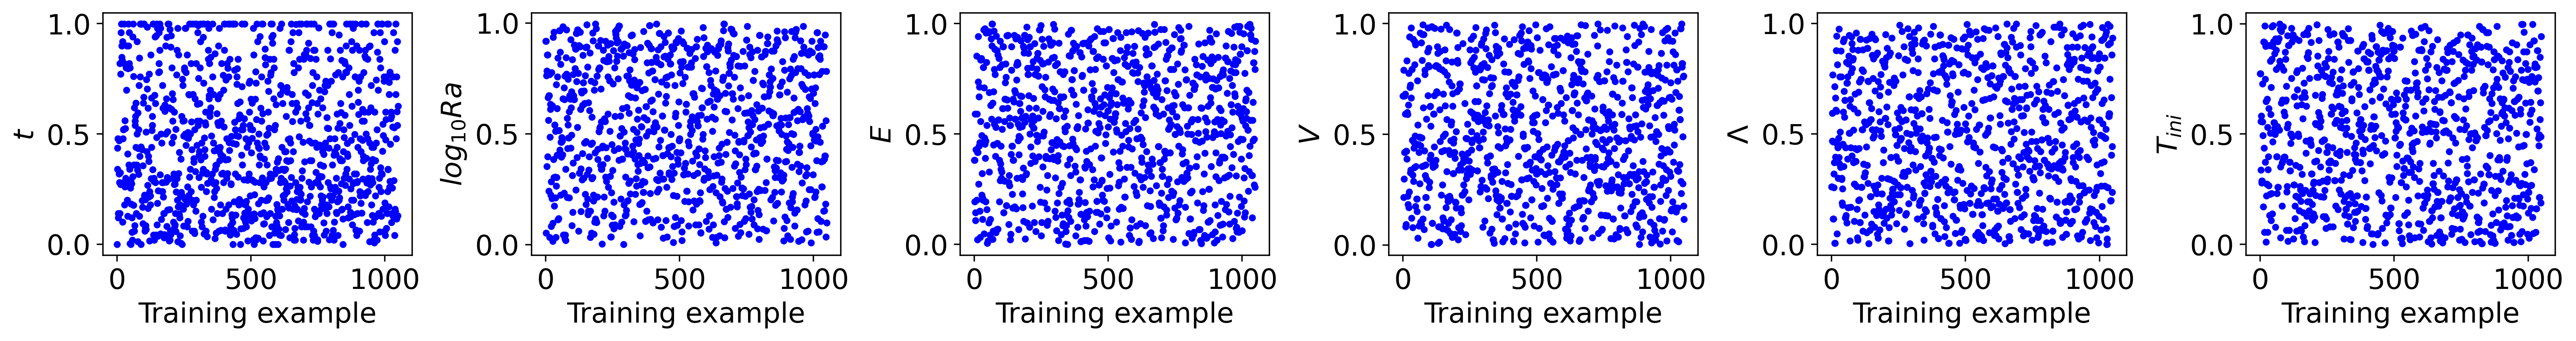

In [8]:
with open(pathSave + "Data/meta_data_dict.txt", "rb") as f:
    x_meta = pickle.load(f)
    
x_min = x_meta["xmin"]
x_max = x_meta["xmax"]

print("Min value of parameters: " + str(x_min))
print("Max value of parameters: " + str(x_max))

### TO DO
for i in range(x_train.shape[1]):
    ### TO DO
    x_train[:,i] =  non_dimensionalize(x_train[:,i],x_min[i],x_max[i])
    
    ### TO DO
    x_cv[:,i]    =  non_dimensionalize(x_cv[:,i],x_min[i],x_max[i])
    
    ### TO DO
    x_test[:,i]  =  non_dimensionalize(x_test[:,i],x_min[i],x_max[i])
    
print()
print("Visualizing the scaled data")
visualize_parameters()

# Module 2/3: Training regression algorithms

### Define a function that builds a Keras network

Let's define a function that defines and returns an untrained Keras network. It has three main components: <br>
1. **Input:** Define the shape of the input (only the second, *never* the batch shape) using *tf.keras.layers.Input(shape=(second dimension of x,))*
2. **Hidden layer:** Define the hidden layers for a "deep" neural network using *tf.keras.layers.Dense(units, activation="tanh")*. Other activations are also available such as "relu", "selu", etc.
3. **Output:** Define the output layer also using a *tf.keras.layers.Dense(second dimension of y)*, but with no activation. The shape of the last layer much match the shape of the output (the shape of the temperature profile in our case).

<img src="Diagrams-NN-Specific.svg" alt="Drawing" style="width: 720px;"/>

We can build this function to flexibly build a network with any number and size of hidden layers through the input argument *numNeurons=[]*. No hidden layers (i.e. *numNeurons=[]*) reduces the model to a linear regression model of the form (y = mx + b). By specifying, for example, *numNeurons=[300, 300]*, 2 hidden layers with 300 units are specified.

We also compile the network within this function and specify the loss function (mean squared error; see https://keras.io/api/losses/ for more) and the optimizer to train the network weights (Adam; see https://keras.io/api/optimizers/ for more). 

In [9]:
def build_network(numNeurons=[]):

    ### TO DO
    x = tf.keras.layers.Input(shape=(6,))
    h = x

    for units in numNeurons:
        ### TO DO
        h = tf.keras.layers.Dense(units, activation="tanh")(h)

    ### TO DO
    y = tf.keras.layers.Dense(302, activation=None)(h)

    network = tf.keras.models.Model(inputs=x, outputs=y)
    network.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")             
    
    return network

### Build a linear regression model

Let's use *build_network()* to define a linear regression model (no hidden layers)

In [10]:
numNeurons_linear = []
NN_linear = build_network(numNeurons_linear)
NN_linear.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 302)               2114      
Total params: 2,114
Trainable params: 2,114
Non-trainable params: 0
_________________________________________________________________


### Train the linear regression model

Now let's train *NN_linear*. 

In [11]:
# Define a session
tf.config.set_soft_device_placement(True)
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# The name under which the trained network is saved
nameNetwork_linear = str(numNeurons_linear) + "_" + str(numTrainingSims)

# Define a learning rate scheduler
def scheduler(epoch):
    _learnRate = 1e-3
    if epoch < 5:
        return _learnRate
    elif epoch >= 5 and epoch < 20:
        return _learnRate/10
    else:
        return _learnRate/100

# Define the callbacks
lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)
csvlogger   = tf.keras.callbacks.CSVLogger(pathSave+"TrainedNetworks/"+ nameNetwork_linear+".txt",separator=",",append=False)
cp          = tf.keras.callbacks.ModelCheckpoint(pathSave+"TrainedNetworks/"+nameNetwork_linear+".hdf5",save_best_only=True)

# Fit the network
ae = NN_linear.fit(x_train,y_train,
            verbose=1,
            epochs=30,
            batch_size=32,
            callbacks=[cp, lr_scheduler, csvlogger],
            validation_data=(x_cv, y_cv),
            shuffle=True) 

# Close the session
session.close()

Epoch 1/30
3280/3280 [==============================] - 4s 1ms/step - loss: 0.0894 - val_loss: 0.0041
Epoch 2/30
3280/3280 [==============================] - 3s 869us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 3/30
3280/3280 [==============================] - 3s 891us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/30
3280/3280 [==============================] - 3s 971us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/30
3280/3280 [==============================] - 3s 898us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/30
3280/3280 [==============================] - 3s 887us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/30
3280/3280 [==============================] - 3s 890us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/30
3280/3280 [==============================] - 3s 837us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/30
3280/3280 [==============================] - 3s 838us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/30
3280/3280 [==============================] - 3s 792us/

### <font color='blue'>Set up a deep neural network</font>

Let's repeat setting up the network, but this time with some hidden layers.

In [12]:
numNeurons_nonlinear = [302, 302, 302]
### TO DO
NN_deep = build_network(numNeurons_nonlinear)
NN_deep.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 302)               2114      
_________________________________________________________________
dense_2 (Dense)              (None, 302)               91506     
_________________________________________________________________
dense_3 (Dense)              (None, 302)               91506     
_________________________________________________________________
dense_4 (Dense)              (None, 302)               91506     
Total params: 276,632
Trainable params: 276,632
Non-trainable params: 0
_________________________________________________________________


### <font color='blue'>Train the deep neural network</font>

In [13]:
### TO DO
# Define a session
tf.config.set_soft_device_placement(True)
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### TO DO
# Name the network
nameNetwork_nonlinear = str(numNeurons_nonlinear) + "_" + str(numTrainingSims)

### TO DO
# Define the callbacks
csvlogger=tf.keras.callbacks.CSVLogger(pathSave+"TrainedNetworks/"+ nameNetwork_nonlinear+".txt",separator=",",append=False)
cp       =tf.keras.callbacks.ModelCheckpoint(pathSave+"TrainedNetworks/"+nameNetwork_nonlinear+".hdf5",save_best_only=True)

### TO DO
# Train the network
ae = NN_deep.fit(x_train,y_train,
            verbose=1,
            epochs=60,
            batch_size=32,
            callbacks=[cp, lr_scheduler, csvlogger],
            validation_data=(x_cv, y_cv),
            shuffle=True) 

### TO DO
# Close the session
session.close()

Epoch 1/60
3280/3280 [==============================] - 9s 3ms/step - loss: 0.0092 - val_loss: 3.1296e-04
Epoch 2/60
3280/3280 [==============================] - 8s 2ms/step - loss: 2.9439e-04 - val_loss: 2.0880e-04
Epoch 3/60
3280/3280 [==============================] - 8s 3ms/step - loss: 2.0854e-04 - val_loss: 1.9118e-04
Epoch 4/60
3280/3280 [==============================] - 8s 2ms/step - loss: 1.6843e-04 - val_loss: 1.5316e-04
Epoch 5/60
3280/3280 [==============================] - 8s 2ms/step - loss: 1.4098e-04 - val_loss: 1.0446e-04
Epoch 6/60
3280/3280 [==============================] - 8s 2ms/step - loss: 7.7707e-05 - val_loss: 8.3578e-05
Epoch 7/60
3280/3280 [==============================] - 8s 3ms/step - loss: 7.4900e-05 - val_loss: 7.7699e-05
Epoch 8/60
3280/3280 [==============================] - 8s 3ms/step - loss: 7.1425e-05 - val_loss: 7.5001e-05
Epoch 9/60
3280/3280 [==============================] - 8s 2ms/step - loss: 6.9176e-05 - val_loss: 7.2596e-05
Epoch 10/60
32

# Module 3/3: Load trained networks

### Visualize loss functions

Here, we visualize the evolution of the training and cross-validation losses during the training of the linear and non-linear neural network

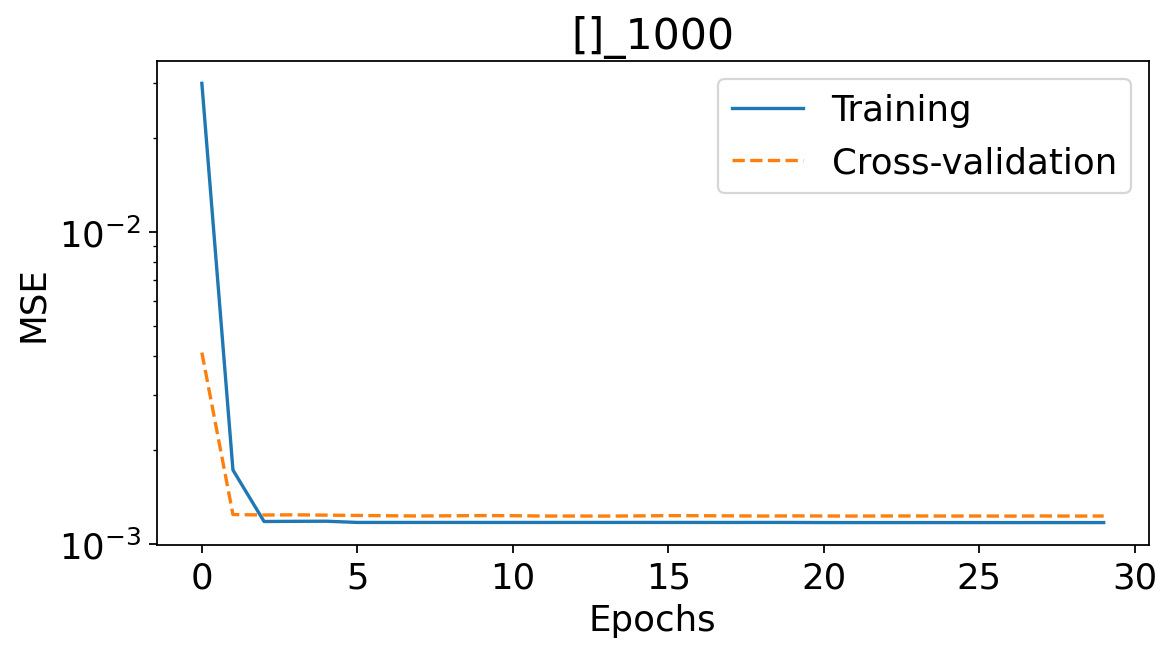

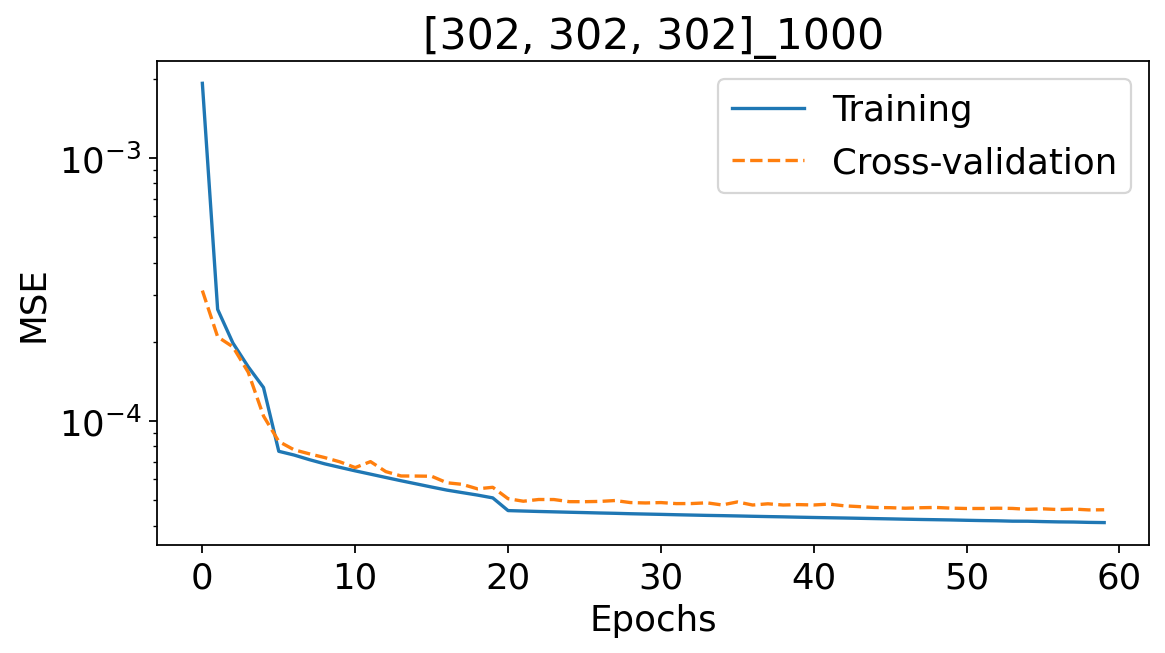

In [14]:
l = {}
l_cv = {}
for network in [nameNetwork_linear, nameNetwork_nonlinear]:
    l_tmp = []
    l_cv_tmp = []
    f = open(pathSave + "TrainedNetworks/" + network + ".txt", "r")
    lines = f.readlines()   
    for _l in lines[1:]:
        l_tmp.append(float(_l.split(',')[1]))
        l_cv_tmp.append(float(_l.split(',')[3]))

    fig = plt.figure(figsize=(8,4), dpi=160)
    ax = fig.add_subplot(1,1,1)
    ax.plot(l_tmp   , '-' ,label="Training")
    ax.plot(l_cv_tmp, '--',label="Cross-validation") 
    ax.set_yscale("log")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MSE")
    ax.set_title(network)
    ax.legend()
    plt.show()
    
    l[network] = l_tmp
    l_cv[network] = l_cv_tmp

### <font color='blue'>Visualize and compare the  predictions of the two networks</font>
Let's use the trained networks to predict temperature profiles in the test-set.

First, we need to load the trained model using *tf.keras.models.load_model*(path to saved network) <br>
Then, we use the loaded network to make predictions on the test-set using *y = model.predict(x)*

[]_1000
MSE on train set: 0.0011696448782458901
MSE on CV set: 0.0012277336791157722
MSE on test set: 0.001316851470548155


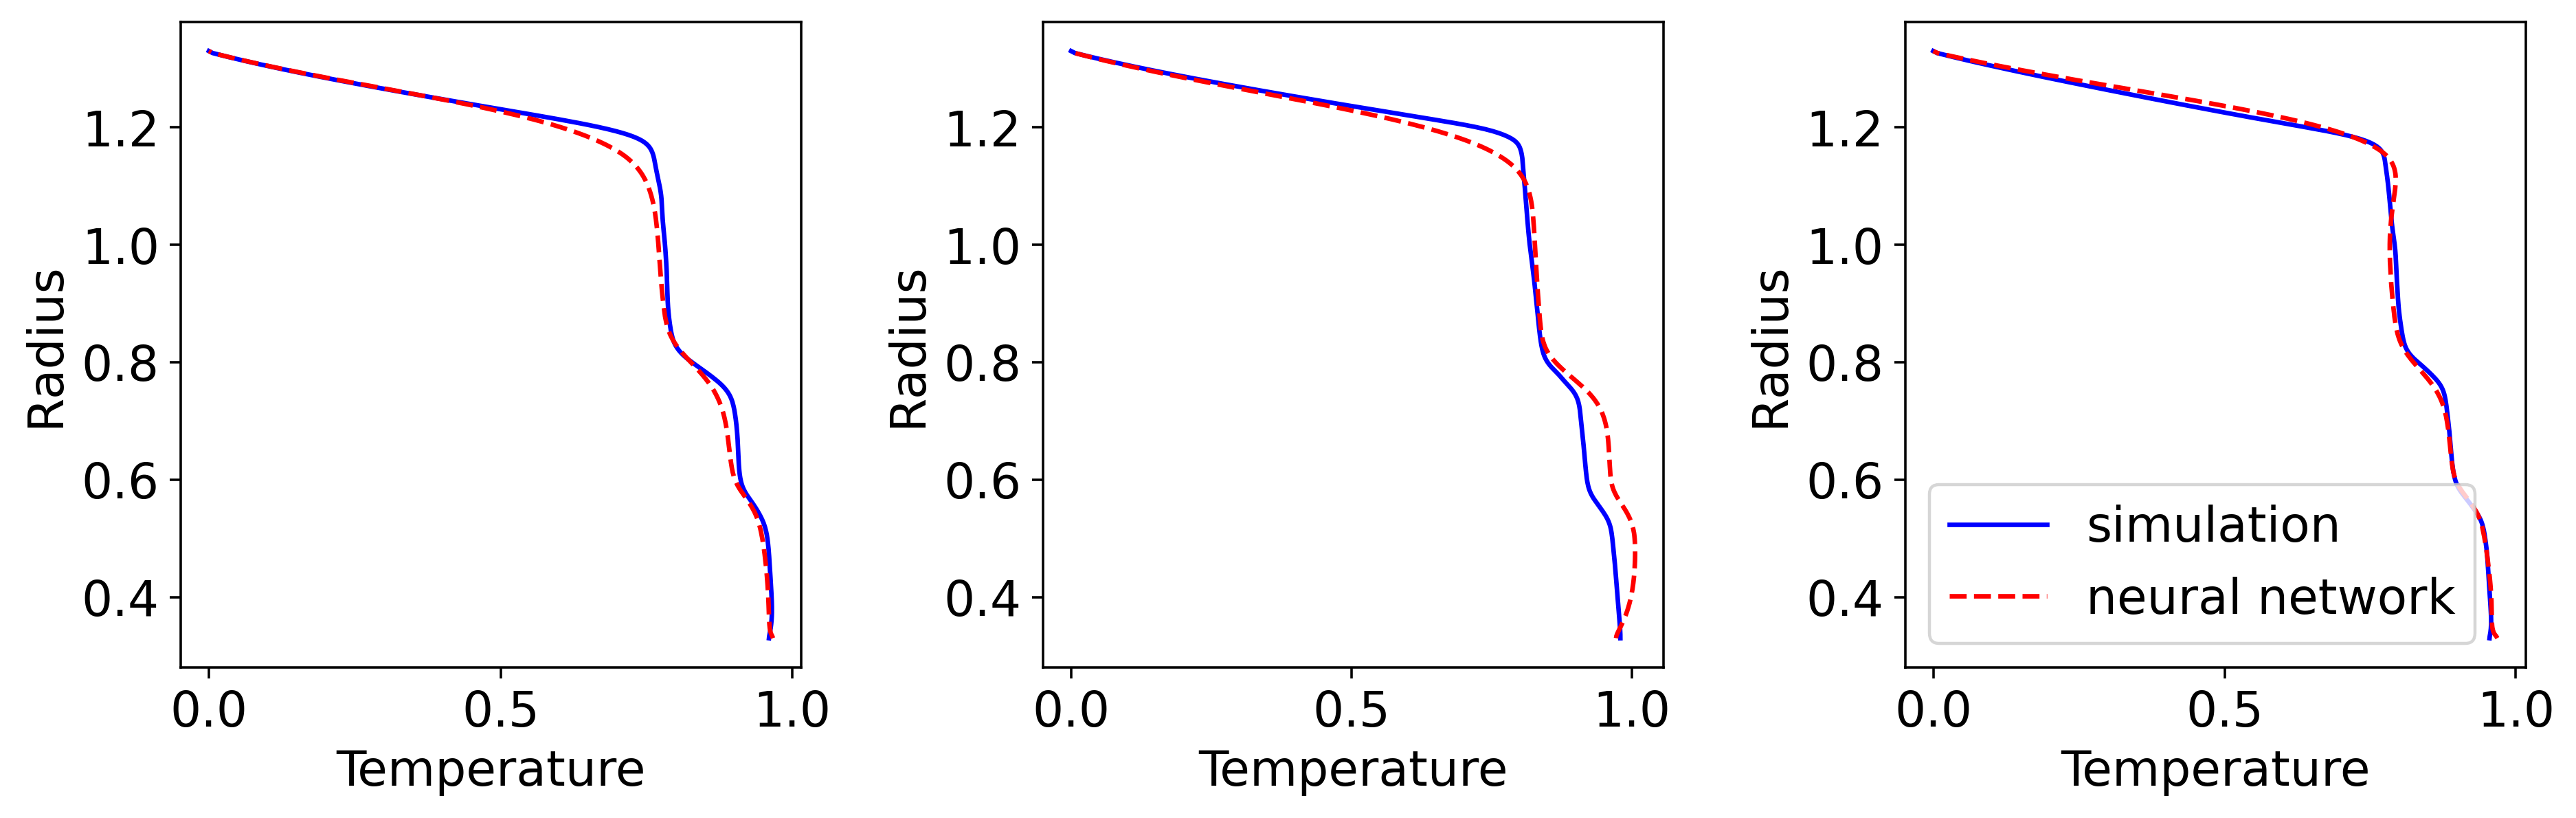

------------------------------------------------------------------------------------------------------
[302, 302, 302]_1000
MSE on train set: 4.109983638045378e-05
MSE on CV set: 4.598342638928443e-05
MSE on test set: 4.642284027774275e-05


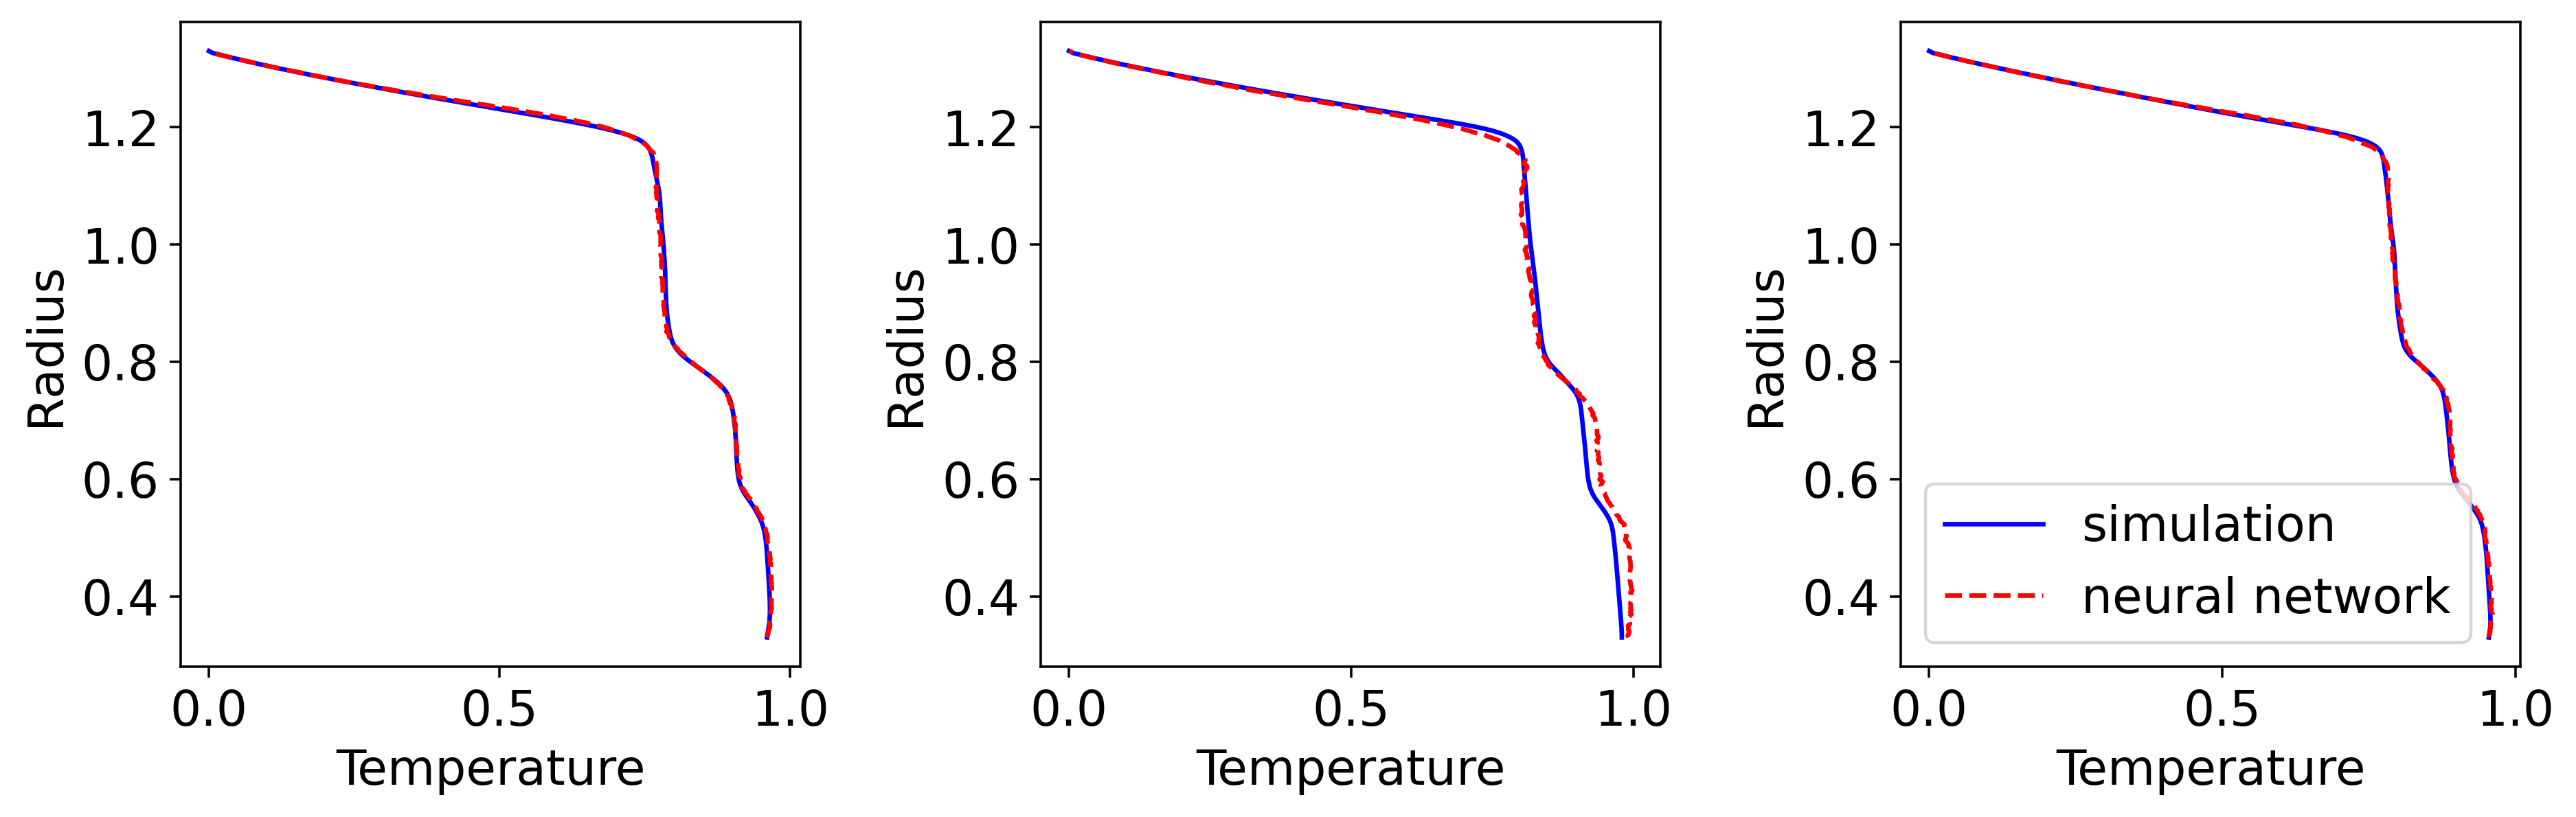

------------------------------------------------------------------------------------------------------


In [15]:
for network in [nameNetwork_linear, nameNetwork_nonlinear]:
    print(network)
    
    ### TO DO
    # load the trained model
    NN = tf.keras.models.load_model(pathSave + "TrainedNetworks/" + network + ".hdf5")
    
    ### TO DO
    # use the loaded model to predict
    y_test_ML = NN.predict(x_test)

    print("MSE on train set: " + str(l[network][-1]))  
    print("MSE on CV set: "    + str(l_cv[network][-1]))  
    print("MSE on test set: "  + str(np.mean(np.power(y_test-y_test_ML,2))))        

    # Plot the temperature profiles from simulations vs. the networks
    profile_indices = [120, 1110, 500]
    fig = plt.figure(figsize=(12,4), dpi=320)
    rProf = np.linspace(0.33,1.33,y_test.shape[1])
    pltCount = 1
    for profIndex in profile_indices:
        ax = fig.add_subplot(1,3,pltCount)
        ax.plot(y_test[profIndex,:]   , rProf, "b-",  label="simulation")
        ax.plot(y_test_ML[profIndex,:], rProf, "r--", label="neural network")
        ax.set_xlabel("Temperature")
        ax.set_ylabel("Radius")
        pltCount += 1
    ax.legend()
    plt.tight_layout()
    plt.show()
    print("------------------------------------------------------------------------------------------------------")

# Epilogue


### Some other things to try

- Decrease the dimnesionality of the 1D temperature profiles from 302 to 30(?) using autoencoders.
- Try some regularization schemes like "L2" or "dropout", especially when not enough simulations are available
- Vary hyperparameters such as architctures, learning rates, batch sizes, activation functions
- Train longer (more epochs)

### Expanding to other tasks in mantle convection

<img src="Diagrams-Concept.svg" alt="Drawing" style="width: 720px;"/>


### Some (interesting) references

**For this tutorial**
- Agarwal, S. et al. A machine-learning-based surrogate model of Mars’ thermal evolution. Geo-physical Journal International (2020).

**Numerical code (GAIA)**
- Hüttig, C., Tosi, N. & Moore, W. An improved formulation of the incompressible navier-stokes equations with variable viscosity. Phys. Earth Planet. Inter. 220, 11–18 (2013).

**Reviews**
- Morra, G., Yuen, D. A., Tufo, H. M. & Knepley, M. G. Fresh Outlook in Numerical Methods for Geodynamics – Part 2: Big Data, HPC, Education. In Alderton, D. & Elias, S. A. (eds.) Encyclopedia of Geology, 841–855 (Academic Press, 2020).
- Brunton, S. L., Noack, B. R. & Koumoutsakos, P. Machine Learning for Fluid Mechanics. Annual Review of Fluid Mechanics 52:1, 477-508 (2020).

**Other forward modeling examples**
- Agarwal, S., Tosi, N., Kessel, P., Breuer, D. & Montavon, G. Deep learning for surrogate modeling of two-dimensional mantle convection. Phys. Rev. Fluids 6, 113801 (2021).
- Nonnenmacher, M. & Greenberg, D. S. Deep emulators for differentiation, forecasting, and parametrization in earth science simulators. Journal of Advances in Modeling Earth Systems 13, e2021MS002554 (2021).
- Wandel, N., Weinmann, M. & Klein, R. Learning incompressible fluid dynamics from scratch-towards fast, differentiable fluid models that generalize. In International Conference on Learning Representations (2020).
- Mohan, A. T., Tretiak, D., Chertkov, M. & Livescu, D. Spatio-temporal deep learning models of 3d turbulence with physics informed diagnostics. Journal of Turbulence 21, 484–524 (2020).
- Mohan, A. T., Lubbers, N., Livescu, D. & Chertkov, M. Embedding hard physical constraints in convolutional neural networks for 3d turbulence (2020).
- Shahnas, M. H. & Pysklywec, R. N. Toward a unified model for the thermal state of the planetary mantle – estimations from mean field deep learning. Earth and Space Science, e2019EA000881 (2020).
 
**Inverse modeling examples**
- Agarwal, S. et al. Toward constraining mars’ thermal evolution using machine learning. Earth and Space Science 8, e2020EA001484 (2021).
- Magali, J.K., Bodin, T., Hedjazian, N., Samuel, H. & Atkins, S. Geodynamictomography:constraining upper-mantle deformation patterns from Bayesian inversion of surface waves. Geophysical Journal International 224, 2077–2099 (2020).
- Atkins, S., Valentine, A. P., Tackley, P. J. & Trampert, J. Using pattern recognition to infer parameters governing mantle convection. Physics of the Earth and Planetary Interiors 257, 171 –186 (2016)
- de Wit, R. W. L., Valentine, A. P. & Trampert, J. Bayesian inference of Earth’s radial seismic structure from body-wave traveltimes using neural networks. Geophys. Journal International 195, 408–422 (2013).
- Meier, U., Curtis, A. & Trampert, J. Global crustal thickness from neural network inversion of surface wave data. Geophysical Journal International 169, 706–722 (2007). 